In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    GlobalAveragePooling2D, Reshape, MultiHeadAttention,
    Add, Activation, Concatenate, Lambda
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# dataset directory
dataset_dir = "dataset-allin/best-case/"

# load and preprocess the dataset
data = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    labels='inferred',
    label_mode='int',
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

Found 717 files belonging to 3 classes.


In [2]:
# split the dataset into train, validation, and test sets
def split_dataset(dataset, train_size=0.7, val_size=0.2):
    total_size = dataset.cardinality().numpy()
    train_dataset = dataset.take(int(total_size * train_size))
    val_test_dataset = dataset.skip(int(total_size * train_size))
    val_dataset = val_test_dataset.take(int(total_size * val_size))
    test_dataset = val_test_dataset.skip(int(total_size * val_size))
    return train_dataset, val_dataset, test_dataset

train, val, test = split_dataset(data)

# prefetch for performance
train = train.prefetch(tf.data.AUTOTUNE)
val = val.prefetch(tf.data.AUTOTUNE)
test = test.prefetch(tf.data.AUTOTUNE)

In [3]:
# Get class names and compute class weights for focal loss

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Collect all labels from the training set
train_labels = []
for _, labels in train:
    train_labels.extend(labels.numpy())
train_labels = np.array(train_labels)

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: np.float64(0.9642184557438794), 1: np.float64(0.6464646464646465), 2: np.float64(2.403755868544601)}


In [6]:
# Advanced augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.GaussianNoise(0.05),
])

train = train.map(lambda x, y: (data_augmentation(x), y))

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import (Dense, Dropout, LayerNormalization,
                                     MultiHeadAttention, Add, Input, Reshape, GlobalAveragePooling1D)
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Attention block
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = Add()([x, inputs])

    # Feed-forward block
    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return Add()([x, res])

def build_hybrid_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)

    # CNN Backbone (feature extractor)
    base_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, name="resnet50")
    base_model.trainable = False   # fine-tune later if needed

    x = base_model.output  # shape: (7, 7, 2048)
    x = Reshape((49, 2048))(x)  # Flatten spatial grid into sequence

    # Transformer blocks
    for _ in range(2):  # can increase for more power
        x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=256, dropout=0.1)

    # Pool transformer outputs
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs, outputs)
    return model

# Usage
model = build_hybrid_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# callbacks for training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [9]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    # class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.4355 - loss: 1.6704 - val_accuracy: 0.6328 - val_loss: 0.8750 - learning_rate: 1.0000e-04
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5625 - loss: 1.1826 - val_accuracy: 0.7266 - val_loss: 0.6489 - learning_rate: 1.0000e-04
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.6660 - loss: 0.9187 - val_accuracy: 0.7812 - val_loss: 0.6620 - learning_rate: 1.0000e-04
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.7520 - loss: 0.7331 - val_accuracy: 0.7500 - val_loss: 0.6311 - learning_rate: 1.0000e-04
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7852 - loss: 0.5694 - val_accuracy: 0.8359 - val_loss: 0.4722 - learning_rate: 1.0000e-04
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8047 - loss: 0.5573 - val_accuracy: 0.7969 - val_loss: 0.4468 - learning_rate: 1.0000e-04
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.8027 - loss:

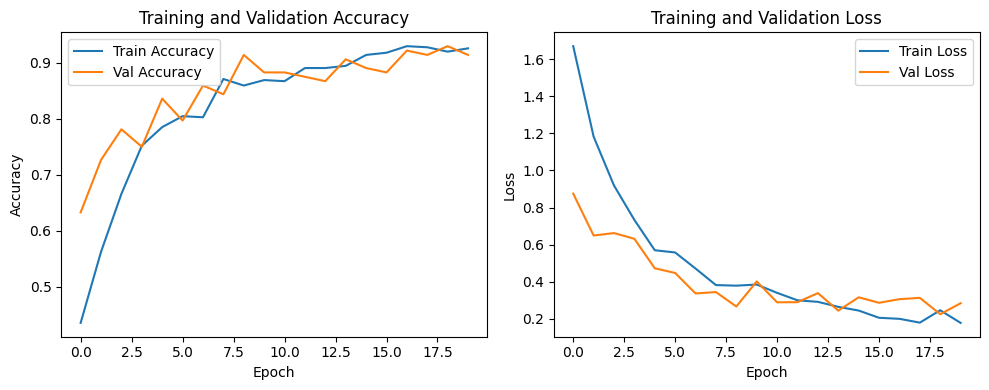

In [10]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_vanilla.h5')

In [12]:
# Stage 2: Unfreeze top ResNet layers (last 30 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8652 - loss: 0.3504 - val_accuracy: 0.8828 - val_loss: 0.3351 - learning_rate: 1.0000e-05
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8828 - loss: 0.3370 - val_accuracy: 0.9297 - val_loss: 0.2299 - learning_rate: 1.0000e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9062 - loss: 0.2357 - val_accuracy: 0.9297 - val_loss: 0.2578 - learning_rate: 1.0000e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8906 - loss: 0.2454 - val_accuracy: 0.9062 - val_loss: 0.2465 - learning_rate: 5.0000e-06
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9023 - loss: 0.2544 - val_accuracy: 0.9453 - val_loss: 0.1792 - learning_rate: 5.0000e-06
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8984 - loss: 0.2355 - val_accuracy: 0.9453 - val_loss: 0.1905 - learning_rate: 5.0000e-06
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9082 - loss:

In [13]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_30layerscnn.h5')

In [14]:
# Stage 2: Unfreeze top ResNet layers (last 60 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-60:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.8867 - loss: 0.2769 - val_accuracy: 0.9375 - val_loss: 0.1525 - learning_rate: 2.0000e-05
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9141 - loss: 0.2091 - val_accuracy: 0.9297 - val_loss: 0.1922 - learning_rate: 2.0000e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9219 - loss: 0.1746 - val_accuracy: 0.9062 - val_loss: 0.2265 - learning_rate: 2.0000e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9434 - loss: 0.1596 - val_accuracy: 0.9453 - val_loss: 0.1812 - learning_rate: 1.0000e-05
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9395 - loss: 0.1489 - val_accuracy: 0.9453 - val_loss: 0.1632 - learning_rate: 1.0000e-05


In [16]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_finetuned60layers.h5')

In [17]:
from tensorflow.keras.metrics import Precision, Recall, Accuracy

pre = Precision()
re = Recall()
acc = Accuracy()

# Evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Test Precision: {pre.result().numpy():.4f}")
print(f"Test Recall: {re.result().numpy():.4f}")
print(f"Test Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Precision: 0.9388
Test Recall: 1.0000
Test Accuracy: 0.9221


In [18]:
# Stage 2: Unfreeze top ResNet layers (last 90 layers)
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-90:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.8789 - loss: 0.2748 - val_accuracy: 0.8828 - val_loss: 0.3869 - learning_rate: 2.0000e-05
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9023 - loss: 0.2182 - val_accuracy: 0.9141 - val_loss: 0.2413 - learning_rate: 2.0000e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9082 - loss: 0.2241 - val_accuracy: 0.9531 - val_loss: 0.1516 - learning_rate: 2.0000e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.9082 - loss: 0.2103 - val_accuracy: 0.9297 - val_loss: 0.1887 - learning_rate: 1.0000e-05
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9121 - loss: 0.2148 - val_accuracy: 0.9297 - val_loss: 0.2252 - learning_rate: 1.0000e-05


In [19]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_finetuned90layers.h5')

In [20]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-150:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(2e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.8730 - loss: 0.3195 - val_accuracy: 0.8828 - val_loss: 0.3471 - learning_rate: 2.0000e-05
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.8984 - loss: 0.2410 - val_accuracy: 0.8906 - val_loss: 0.4154 - learning_rate: 2.0000e-05
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.8984 - loss: 0.2991 - val_accuracy: 0.9062 - val_loss: 0.3387 - learning_rate: 2.0000e-05
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.9023 - loss: 0.2427 - val_accuracy: 0.9453 - val_loss: 0.1506 - learning_rate: 1.0000e-05
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 73s 5s/step - accuracy: 0.9238 - loss: 0.1977 - val_accuracy: 0.8906 - val_loss: 0.3048 - learning_rate: 1.0000e-05


In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Precision: 0.9008
Recall: 0.9147
Accuracy: 0.8261


In [21]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_finetuned150layers.h5')

In [22]:
resnet_layers = [layer for layer in model.layers if layer.name.startswith('conv') or layer.name.startswith('pool')]
for layer in resnet_layers[-200:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-6),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_stage2 = model.fit(
    train,
    validation_data=val,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 119s 6s/step - accuracy: 0.8555 - loss: 0.3530 - val_accuracy: 0.9219 - val_loss: 0.3604 - learning_rate: 1.0000e-06
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 94s 6s/step - accuracy: 0.8789 - loss: 0.2574 - val_accuracy: 0.9141 - val_loss: 0.2765 - learning_rate: 1.0000e-06
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.8535 - loss: 0.3720 - val_accuracy: 0.8984 - val_loss: 0.3961 - learning_rate: 1.0000e-06
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.8633 - loss: 0.2918 - val_accuracy: 0.9531 - val_loss: 0.1941 - learning_rate: 1.0000e-06
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.8555 - loss: 0.3318 - val_accuracy: 0.9219 - val_loss: 0.2492 - learning_rate: 1.0000e-06


In [23]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_finetuned200layers.h5')

In [24]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('checkpoints/FINAL-REAL/hybrid_resnet_transformer_finetuned150layers.h5')

pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision: 0.9123
Recall: 0.9455
Accuracy: 0.8052


In [25]:
# Load the saved model
model = load_model('checkpoints/PROPESI/hybrid_resnet_transformer_finetuned90layers.h5')

for layer in model.layers:
    if hasattr(layer, 'trainable'):
        layer.trainable = False
# Unfreeze transformer layers (those after ResNet output)
for layer in model.layers:
    if 'multi_head_attention' in layer.name or 'dense' in layer.name or 'dropout' in layer.name or 'layer_normalization' in layer.name:
        layer.trainable = True

# Recompile with a low learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune transformer layers
history_transformer = model.fit(
    train,
    validation_data=val,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9414 - loss: 0.1842 - val_accuracy: 0.9297 - val_loss: 0.2191 - learning_rate: 1.0000e-05
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9453 - loss: 0.1544 - val_accuracy: 0.8984 - val_loss: 0.3153 - learning_rate: 1.0000e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9277 - loss: 0.1726 - val_accuracy: 0.9453 - val_loss: 0.1506 - learning_rate: 1.0000e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9395 - loss: 0.1702 - val_accuracy: 0.9141 - val_loss: 0.2625 - learning_rate: 5.0000e-06
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.9512 - loss: 0.1370 - val_accuracy: 0.9297 - val_loss: 0.1634 - learning_rate: 5.0000e-06


In [26]:
pre = Precision()
re = Recall()
acc = Accuracy()

# evaluate the model on the test set
for batch in test.as_numpy_iterator():
    X, y = batch  # unpack the batch
    yhat = model.predict(X)  # get predictions (probabilities)
    yhat_classes = np.argmax(yhat, axis=1)  # convert to class indices

    # update metrics
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)

# print results
print(f"Precision: {pre.result().numpy():.4f}")
print(f"Recall: {re.result().numpy():.4f}")
print(f"Accuracy: {acc.result().numpy():.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Precision: 1.0000
Recall: 0.9796
Accuracy: 0.9870


In [27]:
model.save('checkpoints/PROPESI/hybrid_resnet_transformer_finetunedtransformerlayers.h5')

In [1]:
# Load best model weights
model = load_model('checkpoints/PROPESI/hybrid_resnet_transformer_finetunedtransformerlayers.h5')

# Define simple TTA (horizontal flip, vertical flip, etc.)
def tta_predict(model, image):
    preds = []
    preds.append(model.predict(tf.expand_dims(image, 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_left_right(image), 0))[0])
    preds.append(model.predict(tf.expand_dims(tf.image.flip_up_down(image), 0))[0])
    # Add more augmentations if desired
    return np.mean(preds, axis=0)

# Evaluate with TTA
tta_preds = []
tta_labels = []
for batch in test.as_numpy_iterator():
    X, y = batch
    for img, label in zip(X, y):
        pred = tta_predict(model, img)
        tta_preds.append(np.argmax(pred))
        tta_labels.append(label)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score
print("TTA Precision:", precision_score(tta_labels, tta_preds, average='macro'))
print("TTA Recall:", recall_score(tta_labels, tta_preds, average='macro'))
print("TTA Accuracy:", accuracy_score(tta_labels, tta_preds))

NameError: name 'load_model' is not defined